## Problem 1
Use the rate given by

$$r_{\text{est}}(t)=r_0+\int_{0}^{\infty}d\tau D(\tau)s(t-\tau)$$

with $r_0$ = 50 Hz and

$$D(\tau) = -\cos\left(\frac{2\pi (\tau - 20 \text{ms})}{140 \text{ms}}\right)\exp\left(-\frac{\tau}{60 \text{ms}}\right) \text{Hz/ms}$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white noise stimulus constructed by choosing a stimulus value every 10 ms ($\Delta t$ = 10 ms) from a Gaussian distribution with zero mean and variance $\sigma_s^2/\Delta t$,
with $\sigma_s^2$ = 10. Compute the firing rate over a 10 s period. From the
results, compute the firing rate-stimulus correlation function $Q_{rs}(\tau)$.
Using

$$D(\tau)=\frac{Q_{rs}(\tau)}{\sigma_s^2}=\frac{\langle r \rangle C(\tau)}{\sigma_s^2},$$

compare $Q_{rs}(-\tau)/\sigma_s^2$ with the kernel $D(\tau)$ given above.

    text at line 156 column 10
    legend at line 596 column 29
    text at line 156 column 10
    legend at line 596 column 29


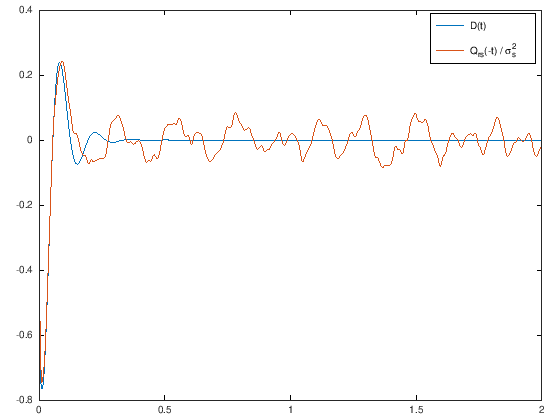

In [20]:
pkg load signal;

T = 10;
dt = 0.001;

var_stim = 10;
dt_stim = 0.01;
stim_steps = T / dt_stim;
stim = randn([1, stim_steps]) * sqrt(var_stim / dt_stim);
stim = repelems(stim, [1:stim_steps; dt_stim / dt * ones(1, stim_steps)]);

r0 = 50;
D = @(tau) -cos(2*pi*(tau - 0.02)/0.14) .* exp(-tau/0.06);
r = @(t) r0 + dt * trapz(D(dt:dt:t) .* stim(int32(t/dt):-1:1));

r_est = [];
for t = dt:dt:T
    r_est = [r_est r(t)];
end

Q_rs = xcov(r_est, stim, "biased");
center = floor(size(Q_rs, 2) / 2);

plot(0:dt:2, D(0:dt:2))
hold on;
plot(0:dt:2, Q_rs(center:center + 2/dt) / var_stim)
hold off;
legend('D(t)', 'Q_{rs}(-t) / \sigma_s^2')

## Problem 2

`c1p8.mat` contains the data described in exercise 8 of chapter 1. Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in

$$r_{\text{est}}(t)=r_0+\int_{0}^{\infty}d\tau D(\tau)s(t-\tau)$$

to provide a model of the response of the H1 neuron. Choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate. Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus `stim`. Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ? Plot the autocorrelation function of the actual and the synthetic spike trains over the range 0 to 100 ms. Why is there a dip at a lag of 2 ms in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too? Plot the interspike interval histogram for both spike trains. Why is there a dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ?

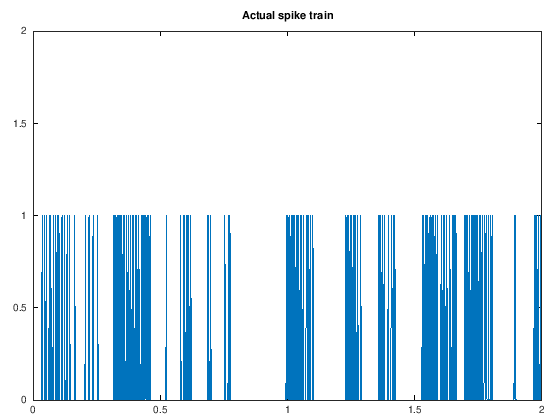

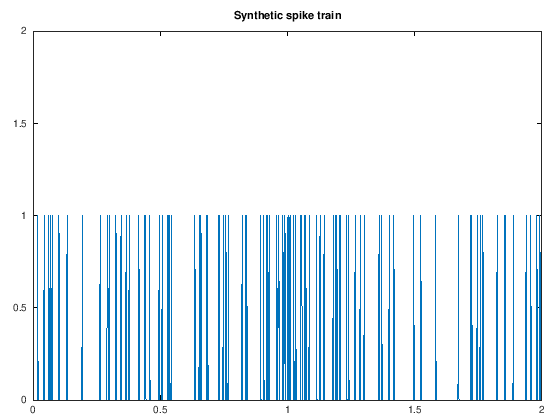

In [2]:
pkg load signal;
load('../data/c1p8.mat');

dt = 0.002;
timesteps = size(stim, 1);
T = timesteps * dt;

window_size = 150;
window = 1-window_size:1:0;

spikes = find(rho);
num_spikes = size(spikes, 1);
spikes = spikes(spikes >= window_size);

s = stim - mean(stim);
triggers = s(spikes + window);
trig_avg = mean(triggers, 1);

D = num_spikes * trig_avg / (var(s) * T);

r0 = num_spikes / T;
r_est = r0 + dt * conv(stim', D(end:-1:1), 'same');

rho_gen = r_est * dt >= rand(size(r_est));

function plot_spike_train(x, plot_title, spike_train_length, dt)
    figure()
    plot(dt:dt:spike_train_length, x(1:spike_train_length/dt));
    title([plot_title, ' spike train']);
    axis([-inf inf 0 2]);
endfunction

spike_train_length = 2;
plot_spike_train(rho, 'Actual', spike_train_length, dt);
plot_spike_train(rho_gen, 'Synthetic', spike_train_length, dt);

The actual spike train shows bursting behavior with longer interburst intervals.

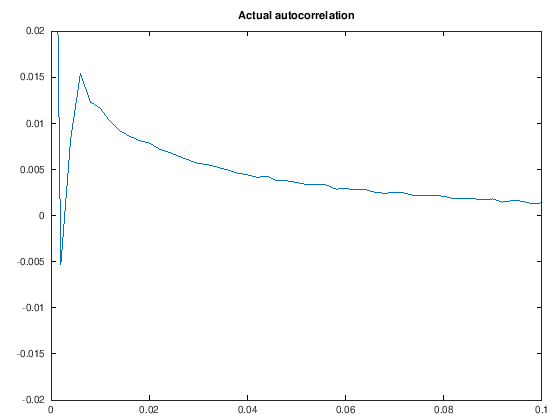

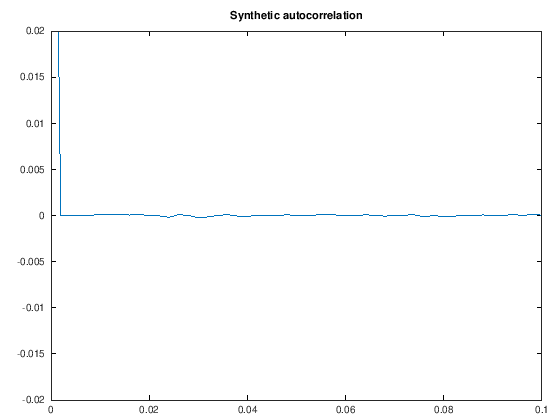

In [3]:
function plot_autocorr(x, plot_title, max_lag_sec, dt)
    max_lag = max_lag_sec / dt;
    autocorr = xcov(x, max_lag, 'biased');
    figure()
    plot(0:dt:max_lag_sec, autocorr(max_lag+1:end));
    axis([0 max_lag_sec -0.02 0.02]);
    title([plot_title, ' autocorrelation']);
endfunction

max_lag = 0.1;
plot_autocorr(rho', 'Actual', max_lag, dt);
plot_autocorr(rho_gen, 'Synthetic', max_lag, dt);

I would assign the dip in autocorrelation for 2ms to the refractory behavior of the actual neuron. The synthetic model does not have any refractory behavior and so lacks this dip.

Actual C_V: 2.0086
Synthetic C_V: 0.95775


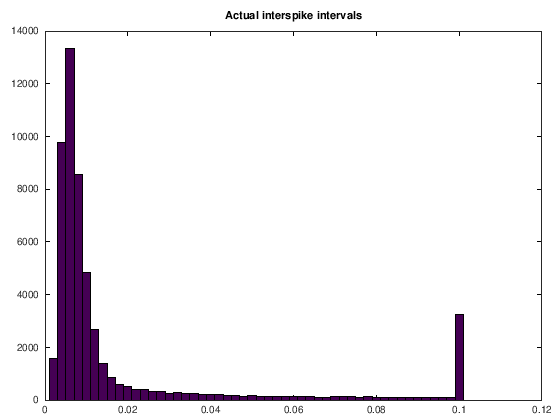

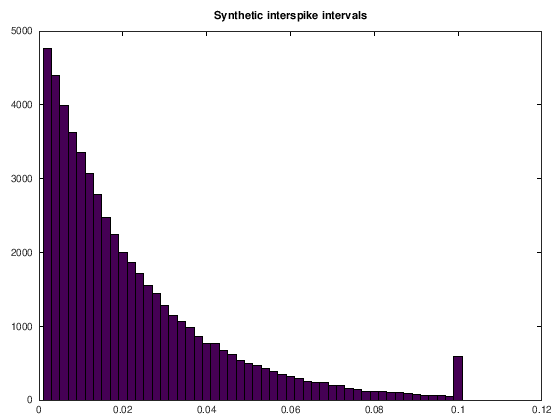

In [4]:
function plot_interspike_intervals(spikes, plot_title, dt)
    spike_times = find(spikes) * dt;
    intervals = spike_times(2:end) - spike_times(1:end-1);
    bins = dt:dt:0.1;
    figure()
    hist(intervals, bins);
    title([plot_title, ' interspike intervals']);
    
    coef_var = std(intervals) / mean(intervals);
    disp([plot_title, ' C_V: ', num2str(coef_var)]);
endfunction

plot_interspike_intervals(rho, 'Actual', dt);
plot_interspike_intervals(rho_gen, 'Synthetic', dt);

I would again assign the dip in interspike intervals below 6ms to refraction. Moreover, you can see that the actual histogram is more tightly centered around 6ms whereas the synethetic histogram is more widely distributed. This reflects the bursting behavior of the actual neuron.

The coefficient of variation of the synethetic spike train is obviously 1 since it is modeled by a Poisson process. As we have seen, the actual neuron is not purely Poisson and so its value deviates from 1.

## Problem 3

`c2p3.mat` contains the responses of a cat LGN cell to two-dimensional visual images (these data are described in Kara, P, Reinagel, P, & Reid, RC (2000) Low response variability in simultaneously recorded retinal, thalamic, and cortical neurons. _Neuron_ **30**:803-817 and were kindly provided by Clay Reid). In the file, `counts` is a vector containing the number of spikes in each 15.6 ms bin, and `stim` contains the 32767, 16 × 16 images that were presented at the corresponding times. Specifically, `stim(x, y, t)` is the stimulus presented at the coordinate `(x,y)` at time-step `t`. Note that `stim` is an `int8` array that must to be converted into `double` using the command `stim=double(stim)` in order to be manipulated within Matlab. Calculate the spike-triggered average images for each of the 12 time steps before each spike and show them all (using the `imagesc` command). Note that in this example, the time bins can contain more than one spike, so the spike-triggered average must be computed by weighting each stimulus by the number of spikes in the corresponding time bin, rather than weighting it by either 1 or 0 depending on whether a spike is present or not. In the averaged images, you should see a central receptive field that reverses sign over time. By summing up the images across one spatial dimension, produce a figure like that of figure 2.25C.

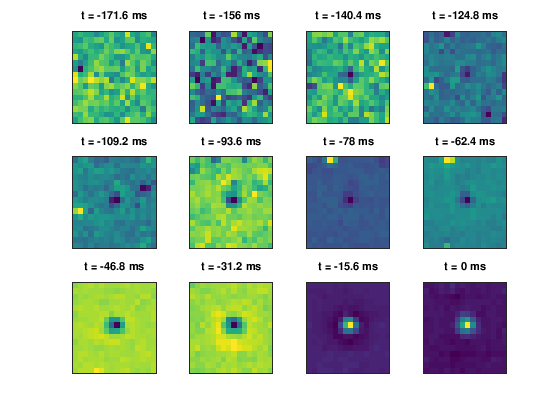

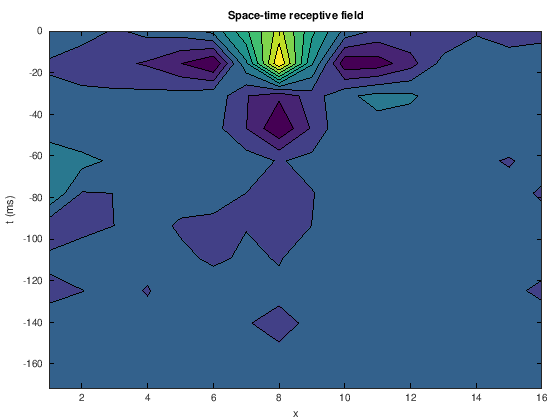

In [129]:
load('../data/c2p3.mat');
stim = double(stim);

sz = size(stim);
window_size = 12;
dt = 15.6;
window = -window_size+1:0;
C = zeros(sz(1), sz(2), window_size);

[i, j, v] = find(counts);
keep = i > window_size;
i = i(keep);
v = v(keep);
for spike = [i v]'
    C = C + spike(2) * stim(1:end, 1:end, spike(1) + window);
end
C = C / sum(v);

cols = 4;
rows = ceil(window_size / cols);
cell_size = 300;
figure('position', [0, 0, cell_size * cols, cell_size * rows])
for t = 1:window_size
    subplot(rows, cols, t);
    imagesc(C(1:end, 1:end, t));
    set(gca, 'xtick', [], 'ytick', []);
    title(['t = ', num2str(dt * (t - window_size)), ' ms']);
end

figure()
st_field = squeeze(sum(C, 2))';
contourf(1:size(C, 2), window * dt, st_field);
xlabel('x');
ylabel('t (ms)');
title('Space-time receptive field');

## Problem 4
For a Gaussian random variable $x$ with zero mean and standard deviation $\sigma$, prove that

$$\langle xF(\alpha x)\rangle=\alpha\sigma^2\langle F'(\alpha x)\rangle,$$

where $\alpha$ is a constant, $F$ is any function, $F'$ is its derivative,

$$\langle xF(\alpha x)\rangle = \int dx \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{x^2}{2\sigma^2}\right)xF(\alpha x),$$

and similarly for $\langle F'(\alpha x)\rangle$. This is the basis of the identity 2.64, which can be derived by extending this basic result first to multivariate functions and then to functionals.

### Proof
Let $u=F(\alpha x)$ and

$$dv=\frac{x}{\sqrt{2\pi}\sigma}\exp\left(\frac{-x^2}{2\sigma^2}\right)dx$$

Then $du = \alpha F'(\alpha x)dx$

$$v = \frac{-\sigma}{\sqrt{2\pi}}\exp\left(\frac{-x^2}{2\sigma^2}\right),$$

and

$$\langle xF(\alpha x)\rangle = \int dx \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{x^2}{2\sigma^2}\right)xF(\alpha x) = \int u dv$$

By integration by parts,

$$\int u dv = uv - \int v du = \left. \frac{-\sigma}{\sqrt{2\pi}}\exp\left(\frac{-x^2}{2\sigma^2}\right)F(\alpha x)
\right|_x -\int dx \frac{-\alpha \sigma}{\sqrt{2\pi}}\exp\left(\frac{-x^2}{2\sigma^2}\right)F'(\alpha x)$$
$$= \left. \frac{-\sigma}{\sqrt{2\pi}}\exp\left(\frac{-x^2}{2\sigma^2}\right)F(\alpha x) \right|_x + \alpha \sigma^2 \langle F'(\alpha x)\rangle$$

At this point, I'm guessing something to do with $x$ having zero mean causes the first term to vanish.

TODO

## Problem 5
Using

$$\epsilon=\epsilon_0(\exp(X/\lambda)-1) \text{  and  } a=-\frac{180^\circ(\epsilon_0 + \epsilon)Y}{\lambda \epsilon \pi},$$

map from cortical coordinates back to visual coordinates and determine what various patterns of activity across the primary visual cortex would “look like”. Ermentrout and Cowan (Ermentrout, GB, & Cowan, J (1979) A mathematical theory of visual hallucination patterns. _Biological Cybernetics_ **34**:137–150) used these results as a basis of a mathematical theory of visual hallucinations. The figure generated by the Matlab program `c2p5.m` shows an illustrative example. This program simulates a plane sine wave of activity across the primary visual cortex with a specified spatial frequency and direction, and then maps it back into retinal coordinates to see what visual pattern would be perceived due to this activity. Consider various other patterns of activity and show the visual hallucinations they would generate.

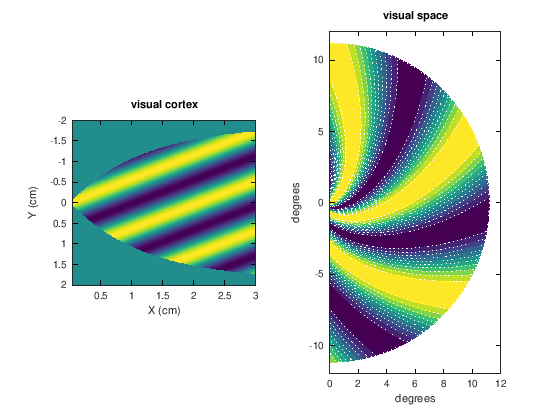

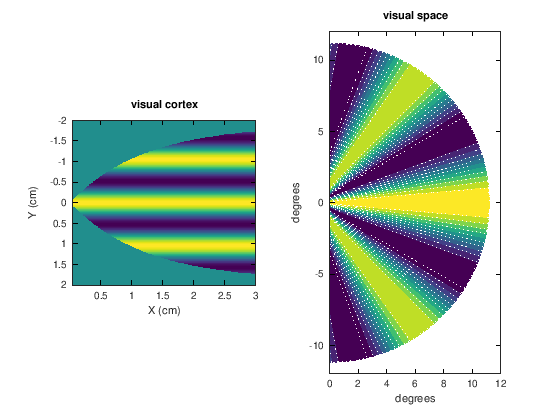

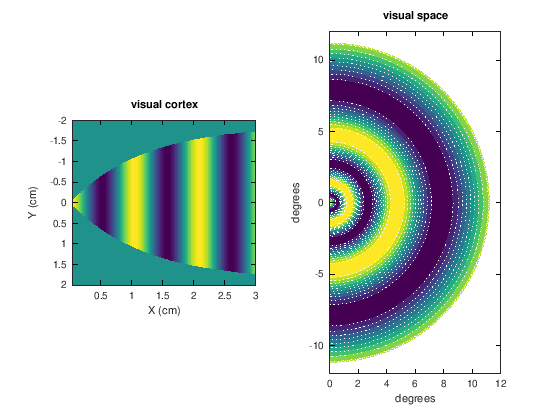

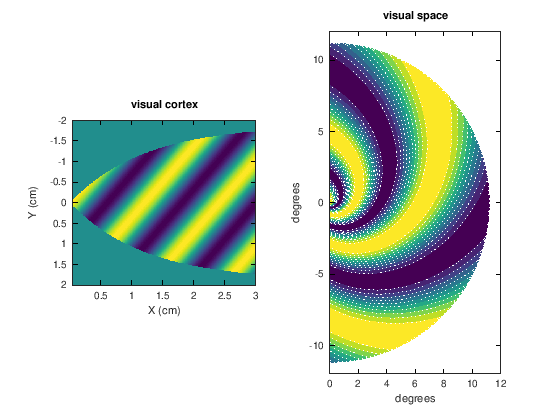

In [128]:
lamda = 1.2;
e0 = 1.0;

[X, Y] = meshgrid(0.05:.01:3, -2:.01:2);

epsilon = e0 * (exp(X/lamda) - 1);
a = -(180 * (e0 + epsilon) .* Y) ./ (lamda * epsilon * pi);
a_valid = abs(a) < 90;
a(a >= 90) = 90;
a(a <= -90) = -90;


for Theta = 0:pi/6:pi/2
    K = 6;
    Phi = 0;
    s = cos(K * X * cos(Theta) + K * Y * sin(Theta) - Phi);

    figure()
    subplot(1, 2, 1);
    imagesc(X(1,:), Y(:,1), s .* a_valid);
    title('visual cortex');
    daspect([1 1.5 1]);
    xlabel('X (cm)');
    ylabel('Y (cm)');


    subplot(1,2,2);
    contourf(epsilon .* cos(a * 2 * pi / 360), epsilon .* sin(a * 2 * pi / 360), s, 'w:');
    axis([0, 12, -12, 12]);
    title('visual space');
    daspect([1 1 1]);
    xlabel('degrees');
    ylabel('degrees');
end

## Problem 6
Perform the below integrals

1)
$$L_s=\int dx dy \frac{A}{2\pi \sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)\cos(kx-\phi)\cos\left(Kx\cos(\Theta)+ Ky\sin(\Theta) - \Phi\right)$$
$$= \frac{A}{2}\exp\left(-\frac{\sigma^2(k^2+K^2)}{2}\right)\left(\cos(\phi-\Phi)\exp\left(\sigma^2kK\cos(\Theta)\right) + \cos(\phi+\Phi)\exp\left(-\sigma^2kK\cos(\Theta)\right)\right)$$

2)
$$L_t(t)=\int_0^\infty d\tau \alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)\cos(\omega(t-\tau))$$
$$=\frac{\alpha^6|\omega| \sqrt{\omega^2+4\alpha^2}}{(\omega^2+\alpha^2)^4}\cos(\omega t - \delta)$$
$$\delta = 8 \arctan\left(\frac{\omega}{\alpha}\right)+\arctan\left(\frac{2\alpha}{\omega}\right)-\pi$$

From these results, verify the selectivity curves in figures 2.15 and 2.16. In addition, plot $\delta$ as a function of $\omega$.

### Solution
1)
Let $a = K \cos(\Theta)$, $b = K\sin(\Theta)$. Then

$$L_s=\int dx dy \frac{A}{2\pi \sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)\cos(kx-\phi)\cos\left(ax+by- \Phi\right)$$

TODO

## Problem 7
Numerically compute the spatial part of the linear response of a simple cell with a separable space-time receptive field to a sinusoidal grating, as given by

$$L_s = \int dx dy D_s(x,y)A\cos\left(Kx\cos(\Theta)+ Ky\sin(\Theta) - \Phi\right)$$

Use a stimulus oriented with $\Theta= 0$. For the spatial receptive field kernel, use

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

with $\sigma_x =\sigma_y = 1^\circ$, $\phi=0$, and $1/k = 0.5^\circ$. Plot $L_s$ as a function of $K$ taking $\Phi=0$ and $A = 50$. This determines the spatial frequency selectivity of the cell. What is its preferred spatial frequency? Plot $L_s$ as a function of $\Phi$ taking $1/K = 0.5^\circ$ and $A = 50$. This determines the spatial phase selectivity of the cell. What is its preferred spatial phase?

### Solution
$$L_s = \int dx dy \frac{A}{2\pi\sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)\cos(kx)\cos(Kx-\Phi) $$

    title at line 53 column 3
    plot_L_s at line 27 column 5
    title at line 53 column 3
    plot_L_s at line 27 column 5
    __axis_label__ at line 30 column 3
    xlabel at line 51 column 8
    plot_L_s at line 28 column 5
    __axis_label__ at line 30 column 3
    xlabel at line 51 column 8
    plot_L_s at line 28 column 5
    __axis_label__ at line 30 column 3
    xlabel at line 51 column 8
    plot_L_s at line 28 column 5
    __axis_label__ at line 30 column 3
    xlabel at line 51 column 8
    plot_L_s at line 28 column 5


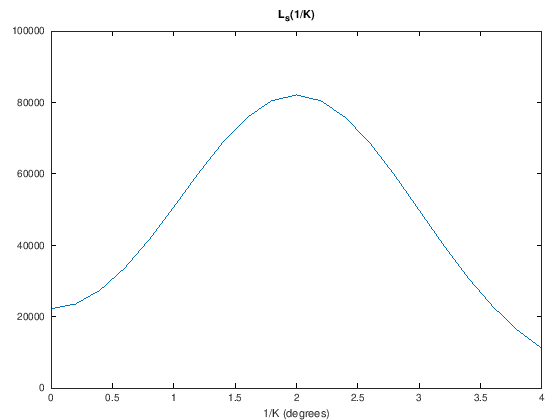

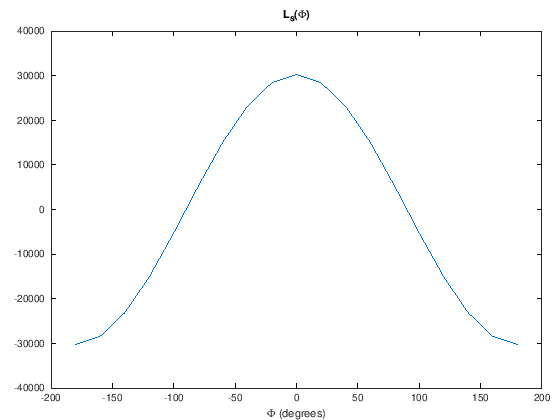

In [33]:
sigma = 1;
k_inv = 0.5;
A = 50;

C = A / (2*pi*deg2rad(sigma)^2);
xa = 10;
L_s = @(K_inv, Phi) C * dblquad(@(x, y) exp(-(x.^2.+y.^2)/(2*sigma^2)).*cos(x/k_inv).*cos(x/K_inv - Phi), -xa, xa, -xa, xa);

function plot_L_s(L_s, K=[], Phi_deg=[])
    Y = [];
    K_inv = 1 ./ K;
    Phi = deg2rad(Phi_deg);
    
    if max(size(K_inv)) == 1
        args = {K_inv, 0};
        arg_ix = 2;
        X_plot = Phi_deg;
        X = Phi;
        variable_name = '\Phi';
    elseif max(size(Phi)) == 1
        args = {0, Phi};
        arg_ix = 1;
        X_plot = K;
        X = K_inv;
        variable_name = '1/K';
    end
    
    for val = X
        args{arg_ix} = val;
        Y = [Y L_s(args{:})];
    end
    
    figure()
    plot(X_plot, Y);
    title(['L_s(',variable_name,')']);
    xlabel([variable_name, ' (degrees)']);
endfunction

plot_L_s(L_s, 0:0.2:4, 0);
plot_L_s(L_s, 0.5, -180:20:180);

With $\Phi=0$ and $A = 50$, the preferred spatial frequency $1/K$ is $2^\circ$. With $1/K = 0.5^\circ$ and $A = 50$, the preferred spatial phase $\Phi$ is $0^\circ$.

## Problem 8
Consider a complex cell with the spatial part of its response given by $L_1^2 + L_2^2$, where $L_1$ and $L_2$ are linear responses determined by

$$L_s = \int dx dy D_s(x,y)A\cos\left(Kx\cos(\Theta)+ Ky\sin(\Theta) - \Phi\right)$$

with kernels given by

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

with $\sigma_x = \sigma_y = 1^\circ$, and $1/k = 0.5^\circ$; and with $\phi = 0$ for $L_1$ and $\phi = -\pi/2$ for $L_2$. Use a stimulus oriented with $\theta = 0$. Compute and plot $L_1^2 + L_2^2$ as a function of $K$ taking $\Phi = 0$ and $A = 5$. This determines the spatial frequency selectivity of the cell. Compute and plot $L_1^2 + L_2^2$ as a function of $\Phi$ taking $1/K = 0.5^\circ$ and $A = 5$. This determines the spatial phase selectivity of the cell. Does the spatial phase selectivity match what you expect for a complex cell?

In [10]:
% TODO

## Problem 9
Consider the linear temporal response for a simple or complex cell given by

$$L_t(t)=\int_0^\infty d\tau D_\tau(\tau)\cos(\omega(t-\tau))$$

with a temporal kernel given by

$$D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)$$

with $1/\alpha = 15$ ms. Compute and plot $L_t(t)$ for $\omega = 6\pi/s$. This determines the temporal response of the simple cell. Do not plot the negative part of $L_t(t)$ because the cell cannot fire at a negative rate. Compute and plot $L_t^2(t)$ for $\omega = 6\pi/s$. This determines the temporal response of a complex cell. What are the differences between the temporal responses of the simple and complex cells?

In [11]:
% TODO

## Problem 10
Compute the response of a model simple cell with a separable space-time receptive field to a moving grating $s(x,y,t) = \cos(Kx - \omega t)$. For $D_s$, use

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

with $\sigma_x = \sigma_y = 1^\circ$, $\phi = 0$, and $1/k = 0.5^\circ$. For $D_t$, use

$$D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)$$

with $1/\alpha = 15$ ms. Compute the linear estimate of the response given by

$$L(t)=\int_0^\infty d\tau\int dx dy D(x, y, \tau)s(x,y,t-\tau)$$

and assume that the actual response is proportional to a rectified version of this linear response estimate. Plot the response as a function of time for $1/K = 1/k = 0.5^\circ$ and $\omega = 8\pi/s$. Plot the response amplitude as a function of $\omega$ for $1/K = 1/k = 0.5^\circ$ and as a function of $K$ for $\omega = 8\pi/s$.

In [12]:
% TODO

## Problem 11
Compute the response of a model complex cell to the moving grating

$$s(x, y, t) = \cos(Kx - \omega t)$$

The complex cell should be modeled by squaring the unrectified linear response estimate of a simple cells with a spatial receptive field given by

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

with $\sigma_x = \sigma_y = 1^\circ$, $\phi = 0$, and $1/k = 0.5^\circ$, and adding this to the square of the unrectified linear response of a second simple cell with identical properties except that its spatial phase preference is $\phi = -\pi/2$ instead of $\phi = 0$. Both linear responses are computed from

$$L(t)=\int_0^\infty d\tau\int dx dy D(x, y, \tau)s(x,y,t-\tau)$$

For both of these, use

$$D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)$$

with $1/\alpha = 15$ ms for the temporal receptive field. Plot the complex cell response as a function of time for $1/K = 1/k = 0.5^\circ$ and $\omega = 8\pi/s$. Plot the response amplitude as a function of $\omega$ for $1/K = 1/k = 0.5^\circ$ and as a function of $K$ for $\omega = 8\pi/s$.

In [13]:
% TODO

## Problem 12
Construct a model simple cell with the nonseparable space-time receptive field described in the caption of figure 2.21B. Compute its response to the moving grating

$$s(x, y, t) = cos(Kx - \omega t)$$

Plot the amplitude of the response as a function of the velocity of the grating, $\omega/K$, using $\omega = 8\pi/s$ and varying $K$ to obtain a range of both positive and negative velocity values (use negative $K$ values for this). Show that the response is directionally selective.

In [14]:
% TODO

## Problem 13
Construct a model complex cell that is disparity tuned but insensitive to the absolute position of a grating. The complex cell is constructed by summing the squares of the unrectified linear responses of two simple cells, but disparity effects are now included. For this exercise, we ignore temporal factors and only consider the spatial dependence of the response. Each simple cell response is composed of two terms that correspond to inputs coming from the left and right eyes. Because of disparity, the spatial phases of the image of a grating in the two eyes, $\Phi_L$ and $\Phi_R$, may be different. We write the spatial part of the linear response estimate for a grating with the preferred spatial frequency $(k = K)$ and orientation $(\Theta = \theta = 0)$ as

$$L_1 = \frac{A}{2}(\cos(\Phi_L ) + \cos(\Phi_R ))$$

assuming that $\phi = 0$ (this equation is a generalization of equation 2.34). Let the complex cell response be proportional to $L_1^2 + L_2^2$, where $L_2$ is similar to $L_1$ but with the cosine functions replaced by sine functions. Show that the response of this neuron is tuned to the disparity, $\Phi_L - \Phi_R$, but is independent of the absolute spatial phase of the grating, $\Phi_L + \Phi_R$. Plot the response tuning curve as a function of disparity. (See DeAngelis, GC, Ohzawa, I, & Freeman, RD (1991) Depth is encoded in the visual cortex by a specialized receptive field structure. _Nature_ **352**:156–159.)

In [15]:
% TODO

## Problem 14
Determine the selectivity of the LGN receptive field of

$$D_s(x,y)=\pm\left(\frac{1}{2\pi \sigma_{cen}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_{cen}^2}\right)-\frac{B}{2\pi \sigma_{sur}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_{sur}^2}\right)\right)$$

to spatial frequency by computing its integrals when multiplied by the stimulus

$$s = \cos(Kx)$$

for a range of $K$ values. Use $\sigma_c = 0.3^\circ$, $\sigma_s = 1.5^\circ$, $B = 5$, $1/\alpha = 16$ ms, and $1/\beta = 64$ ms, and plot the resulting spatial frequency tuning curve.

In [16]:
% TODO

## Problem 15
Construct the Hubel-Wiesel model of a simple-cell spatial receptive field, as depicted in figure 2.27A. Use difference-of-Gaussian functions given by

$$D_s(x,y)=\pm\left(\frac{1}{2\pi \sigma_{cen}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_{cen}^2}\right)-\frac{B}{2\pi \sigma_{sur}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_{sur}^2}\right)\right)$$

to model the LGN receptive fields. Plot the spatial receptive field of the simple cell constructed by summing the spatial receptive fields of the LGN cells that provide its input. Compare the result of summing appropriately placed LGN center-surround receptive fields (figure 2.27A) with the results of an appropriately adjusted Gabor filter model of the simple cell that uses the spatial kernel of

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

In [17]:
% TODO

## Problem 16
Construct the Hubel-Wiesel model of a complex cell, as depicted in figure 2.27B. Use Gabor functions given by

$$D_s(x,y)=\frac{1}{2\pi \sigma_x \sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)$$

to model the simple cell responses, which should be rectified before being summed. Plot the spatial receptive field of the complex cell constructed by summing the different simple cell responses. Compare the responses of a complex cell constructed by linearly summing the outputs of simple cells (figure 2.27B) with different spatial phase preferences with the complex cell model obtained by squaring and summing two unrectified simple cell responses with spatial phases $90^\circ$ apart as in exercise 8.

In [18]:
% TODO